# Imports

In [1]:
### Imports ###
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin

from Data_Merger_Pipeline import DataMerger
from Data_Transformer_Pipeline import Data_Transformer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Helper Functions

In [2]:
def display_scores(clf, X_test, y_test): 
    acc_score = np.mean(cross_val_score(clf, X_test, y_test, scoring='accuracy', cv=5))
    
    name = clf.__class__.__name__
    print('\n'+name+':')
    print('   Accuracy Score:', acc_score,'\n')

# Loading Data

In [3]:
### Loading Data ###
web_data_df = pd.read_csv("Data/Loaded_Data/Web_Data.csv")
github_data_df = pd.read_csv("Data/Loaded_Data/Github_Data.csv")

# Cleaning Data

In [4]:
### Merging Data ###
cols_to_keep = ['Z','N','Mass','Half Life','M']
data_merger = DataMerger(cols_to_keep)
df = data_merger.transform(web_data_df, github_data_df)[1:].reset_index(drop=True)

/Users/elliotgross/Desktop/Nuclear-Physics-ML-master/Nuclear ML/Data_Merger_Pipeline.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  web_data_df['N'] = np.floor(web_data_df['Mass']) - web_data_df['Z']


In [5]:
### Splitting Data And Target Vector ###
X = df.drop('Half Life', axis=1)
y = df['Half Life']

In [6]:
### Preparing Data ###
features_to_keep = ['N','Z','-ZM/N']
data_transformer = Data_Transformer(X_features=features_to_keep, target_vector='Magnitude',
                                    prediction_type='Regression',
                                    X_imputer_strat='drop', X_fill_value='None',
                                    y_imputer_strat='drop', y_fill_value='None')
prepared_X, prepared_y = data_transformer.transform(X, y)

#print(prepared_X.shape, prepared_y.shape)

/Users/elliotgross/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


## Normalizing Data

In [7]:
### Normalizing X-Values ### *Put into Data Transformer Pipeline after deciding on design*
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler().fit(prepared_X)
X_norm = pd.DataFrame(norm.transform(prepared_X), columns=prepared_X.columns)

# Splitting Data

In [8]:
### Splitting Data ### *Clould Be done before or after transforming data*
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_norm,prepared_y,test_size=0.1,random_state=27)  
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,
                                                  random_state=27)

#print(X_train)
#print(y_train)

# Creating/Training Model

In [9]:
### Creating Model ###
degree = 7
polynomial_features = PolynomialFeatures(degree=degree)
X_poly_train = polynomial_features.fit_transform(X_train)
X_poly_test = polynomial_features.fit_transform(X_test)

model = LinearRegression(fit_intercept=True)

### Training Model ###
model.fit(X_poly_train, y_train)

model

LinearRegression()

# Making Predictions

In [10]:
### Test Predictions ###
predictions = model.predict(X_poly_test)
predictions_rounded = [round(n) for n in predictions]

results_df = pd.DataFrame({'y Test':y_test, 'Predictions':predictions,
                           'Predictions Rounded':predictions_rounded}).reset_index(drop=True)

# Scoring 

In [11]:
#r^2 score
print('r^2 Score:', r2_score(y_test, predictions))
print('Explained Variance Score:', explained_variance_score(y_test, predictions))
results_df

r^2 Score: 0.4889702060073472
Explained Variance Score: 0.4890718670231383


,y Test,Predictions,Predictions Rounded
0,0.0,0.813143,1
1,-2.0,-1.362560,-1
2,2.0,4.365634,4
3,1.0,0.666474,1
4,4.0,2.499257,2
...,...,...,...
269,6.0,3.539216,4
270,2.0,3.448004,3
271,2.0,1.486505,1
272,2.0,3.170331,3


Text(96.0, 0.5, 'true value')

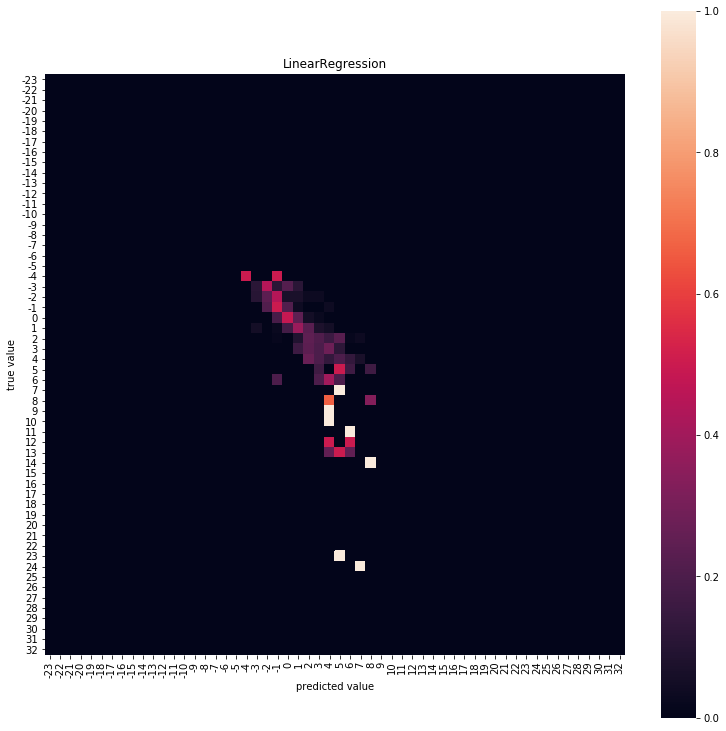

In [12]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(13, 13))

mat = confusion_matrix(y_test, predictions_rounded,
                       labels=np.arange(-23,33), normalize='true')
matrix = pd.DataFrame(mat, columns=np.arange(-23,33))
matrix = matrix.set_index(np.arange(-23,33))

sns.heatmap(matrix, square=True, annot=False, cbar=True, xticklabels=True)
plt.title(model.__class__.__name__)
plt.xlabel('predicted value')
plt.ylabel('true value')